In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from scipy.spatial.distance import cosine
from nlp_tools import VAD, text_processing, word_embedding as tools

warnings.filterwarnings("ignore")
pd.set_option('mode.copy_on_write', True)
rng = np.random.default_rng(seed=42)

# set up word2vec model and wordlists

target_group = ["migrant", "immigrant", "immigration", "refugee"]
control_group = ["british", "briton", "britain", "english"]
model_all = tools.get_word2vec_model("BBC_Daily mail_Metro")

vermin_words = ["vermin", "rodent", "rodents", "rat", "rats", "mice", "cockroaches", "termite", "termites", "bedbug", "bedbugs", "fleas"]
moral_disgust_ref = 10 # 'PurityVice'
md_ignore = ["tramp"]
get = lambda list, idx: list[idx]

with open("data/lexicon/moral foundations dictionary.dic") as file:
    raw = file.read()
series = pd.Series(raw.split("\n")).apply(str.split)
series = series[series.apply(len) > 1][11:]
dict_keys = series.apply(get, idx=1).apply(int)
moral_disgust_words = series.apply(get, idx=0).str.replace("*", "")[dict_keys == moral_disgust_ref]


In [ ]:
## Set up functions

def permut_test_vector_similarity(row, group1=target_group, group2=control_group, n=100, output=False, model=model_all):
    def get_difference(group1_permutation, group2_permutation):
        group1_vec = tools.get_word_vector(group1_permutation, model=model)
        group2_vec = tools.get_word_vector(group2_permutation, model=model)
        group1_similarity = 1 - cosine(row["vector"], group1_vec)
        group2_similarity = 1 - cosine(row["vector"], group2_vec)
        difference = group1_similarity - group2_similarity
        return difference

    n_group1 = len(group1)
    pooled = np.concatenate([group1, group2])
    shuffled = rng.permutation(pooled)
    permutation_results = np.array(np.zeros(n))

    for i in range(n):
        shuffled = rng.permutation(pooled)
        group1_permutation = shuffled[:n_group1]
        group2_permutation = shuffled[n_group1:]
        difference = get_difference(group1_permutation, group2_permutation)
        permutation_results[i] = difference
        if output: print(group1_permutation, difference)

    actual_difference = get_difference(group1, group2)
    if output: print(actual_difference)
    if row["difference"] > 0:
        n_as_high = np.count_nonzero(permutation_results >= actual_difference)         
    else:
        n_as_high = np.count_nonzero(permutation_results <= actual_difference)

    p = n_as_high / n
    return p

def compare(group1, group2, target_words, output="compare", model=model_all):
    vec1 = tools.get_word_vector(group1, model=model)
    vec2 = tools.get_word_vector(group2, model=model)
    target = tools.get_word_vector(target_words, model=model_all)

    groups_similarity = 1 - cosine(vec1, vec2)
    group1_similarity = 1 - cosine(vec1, target)
    group2_similarity = 1 - cosine(vec2, target)
    if "compare" in output:
        print(group1_similarity, group2_similarity)
        if group1_similarity > group2_similarity:
            print("{} group closer to {} group".format(group1[0], list(target_words)[0]))
        else:
            print("{} group closer to {} group".format(group2[0], list(target_words)[0]))
    if "between" in output:
        print(groups_similarity)
    if "return" in output:
        return groups_similarity, group1_similarity, group2_similarity

def get_vec(words, model=model_all):
    if len(words) == 1 and words[0] in model.wv:
        return model.wv[words[0]], model.wv.get_vecattr(words[0], "count")
    else:
        try:
            return tools.get_word_vector(words, model=model, return_count=True)
        except ZeroDivisionError:
            return np.nan, np.nan

In [ ]:
## Set up composite vectors and run main analysis

migrant_vec = tools.get_word_vector(target_group, model=model_all)
control_vec = tools.get_word_vector(control_group, model=model_all)

dehuman_metaphors = {
    "moral disgust": moral_disgust_words.to_list(),
    "vermin": vermin_words,
    "infestation": ["infest", "infestation"],
    "flood": ["flood", "wave", "surge", "tide"],
    "water": ["water"],
    }

# Get composite vectors for each dehumanizing concept / metaphot
dehuman_vecs = pd.DataFrame()
dehuman_vecs["name"] = dehuman_metaphors.keys()
dehuman_vecs["words"] = dehuman_metaphors.values()
data = dehuman_vecs["words"].apply(get_vec, model=model_all)
dehuman_vecs["count"] = data.apply(get, idx=1)
dehuman_vecs["vector"] = data.apply(get, idx=0)
dehuman_vecs.dropna(inplace=True)

# Get similarity difference for each composite vector
similarity = lambda vec1, vec2: 1 - cosine(vec1, vec2)
dehuman_vecs["migrant_similarity"] = dehuman_vecs["vector"].apply(similarity, vec2=migrant_vec)
dehuman_vecs["control_similarity"] = dehuman_vecs["vector"].apply(similarity, vec2=control_vec)
dehuman_vecs["difference"] = dehuman_vecs["migrant_similarity"] - dehuman_vecs["control_similarity"]
dehuman_vecs.sort_values(by="difference", ascending=False)

,name,words,count,vector,migrant_similarity,control_similarity,difference
3,flood,"[flood, wave, surge, tide]",669.0,"[-0.06937876, 0.14237262, -0.046662178, 0.0231...",0.287931,0.091005,0.196926
2,infestation,"[infest, infestation]",8.0,"[-0.13917698, 0.10733219, -0.048854355, 0.0283...",0.342862,0.280405,0.062457
4,water,[water],682.0,"[0.4446178, -0.81007475, -0.43783113, 0.156976...",0.133879,0.101840,0.032038
0,moral disgust,"[disgust, deprav, disease, unclean, contagio, ...",347.5,"[0.025112106, -0.032231245, 0.032657586, -0.08...",0.254614,0.338530,-0.083917
1,vermin,"[vermin, rodent, rodents, rat, rats, mice, coc...",20.0,"[-0.06536166, 0.03288035, -0.036171753, 0.0935...",0.142712,0.418666,-0.275954


In [ ]:
## Permutation testing

dehuman_vecs["p"] = dehuman_vecs.apply(permut_test_vector_similarity, axis=1, n=1000)
dehuman_vecs

,name,words,count,vector,migrant_similarity,control_similarity,difference,p
0,moral disgust,"[disgust, deprav, disease, unclean, contagio, ...",347.5,"[0.025112106, -0.032231245, 0.032657586, -0.08...",0.254614,0.338530,-0.083917,0.076
1,vermin,"[vermin, rodent, rodents, rat, rats, mice, coc...",20.0,"[-0.06536166, 0.03288035, -0.036171753, 0.0935...",0.142712,0.418666,-0.275954,0.013
2,infestation,"[infest, infestation]",8.0,"[-0.13917698, 0.10733219, -0.048854355, 0.0283...",0.342862,0.280405,0.062457,0.514
3,flood,"[flood, wave, surge, tide]",669.0,"[-0.06937876, 0.14237262, -0.046662178, 0.0231...",0.287931,0.091005,0.196926,0.012
4,water,[water],682.0,"[0.4446178, -0.81007475, -0.43783113, 0.156976...",0.133879,0.101840,0.032038,0.387


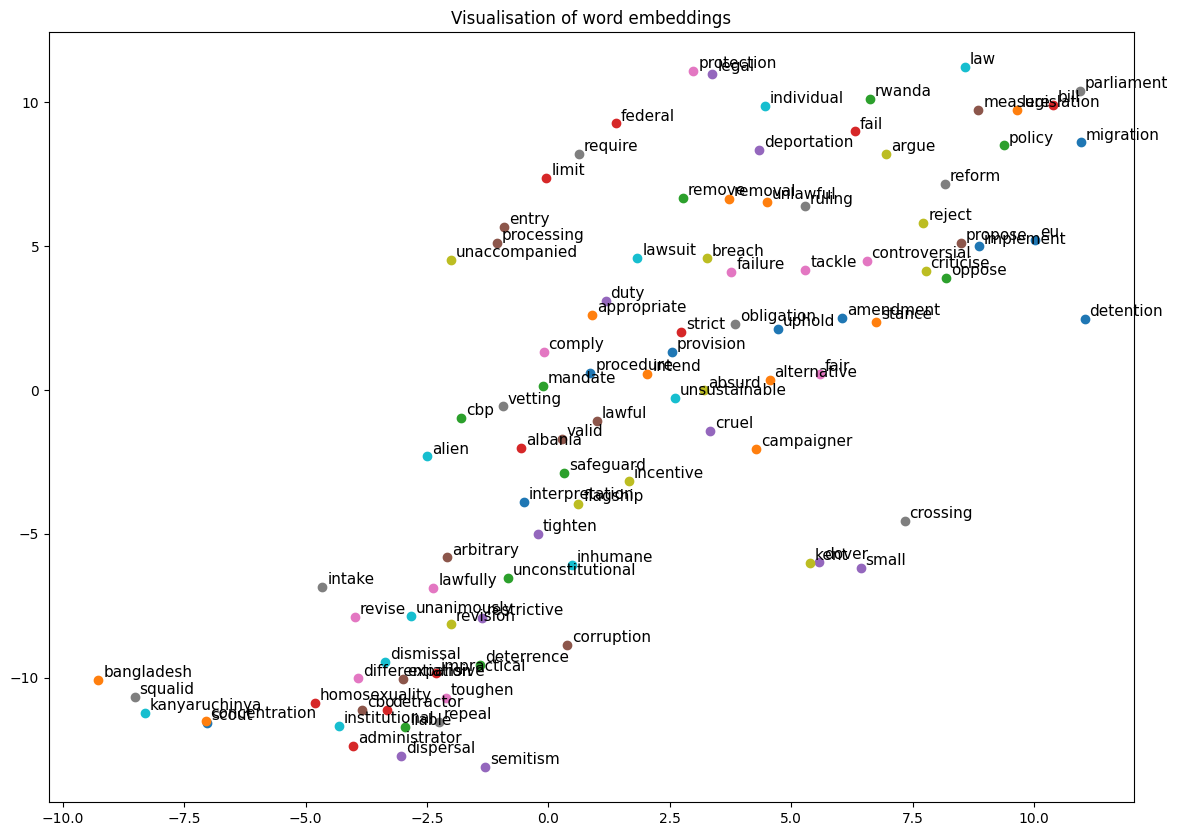

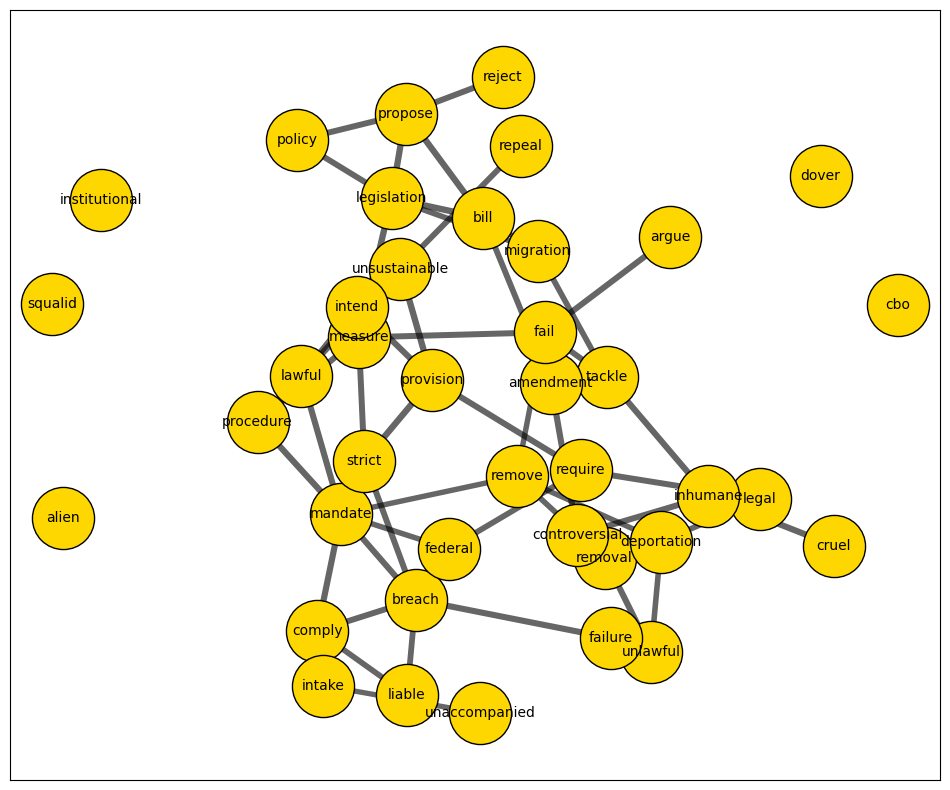

In [79]:
## Additional visualisations

migrant_neighbours = tools.get_nearest_neighbours(target_group, k=100)
words = migrant_neighbours.sort_values(by="dist", ascending=False)["word_lemmatized"].values
words_alt = [i for i, x in model_all.wv.similar_by_vector(migrant_vec, topn=40)]
tools.visualise_vectors_scatter(words[:100], model=model_all, offset=0.1)
plt.show()
tools.visualise_vectors_network(words[:40], model=model_all);